In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('data/train.csv')
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)
print(data.shape)

(42000, 785)


In [4]:
data_train = data[0:int(m*0.9)].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.

data_dev = data[int(m*0.9):m].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

print(X_train.shape, Y_train.shape, X_dev.shape, Y_dev.shape)

(784, 37800) (37800,) (784, 4200) (4200,)


In [5]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def ReLU_deriv(Z):
    return Z > 0

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)

    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [6]:
from tqdm import trange

def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def get_loss_mse(predictions, Y):
    return np.sum((Y-predictions)**2) / Y.size

def get_loss_xentropy(predictions, targets, epsilon=1e-10):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce_loss = -np.sum(np.sum(targets * np.log(predictions + 1e-5)))/N
    return ce_loss

def gradient_descent(X, Y, alpha, iterations):
    accuracies, losses = [], []
    W1, b1, W2, b2 = init_params()
    for i in (t := trange(iterations)):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        predictions = get_predictions(A2)
        accuracy, loss = get_accuracy(predictions, Y), get_loss_mse(predictions, Y) / 100
        accuracies.append(accuracy)
        losses.append(loss)
        t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
    return W1, b1, W2, b2, accuracies, losses

def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

In [7]:
W1, b1, W2, b2, accuracies, losses = gradient_descent(X_train, Y_train, 0.10, 500)

loss 0.02 accuracy 0.84: 100%|██████████| 500/500 [01:27<00:00,  5.68it/s]


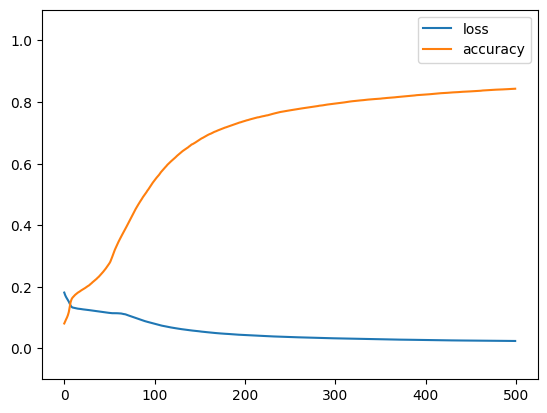

In [8]:
import matplotlib.pyplot as plt

plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)
plt.legend(['loss', 'accuracy'], loc='upper right')

In [9]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

0.85

[6]# Label: 4 | Pred: [8]


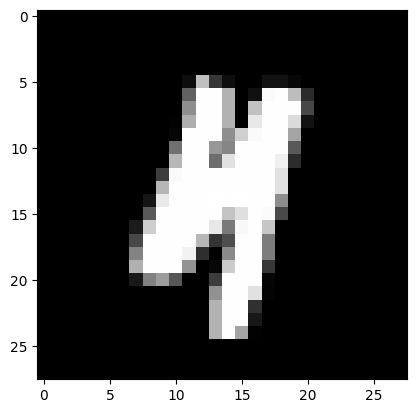

In [10]:
# Check first label and prediction difference

for idx in range(len(X_train)):
    current_image = X_train[:, idx, None]
    label = Y_train[idx]
    prediction = make_predictions(current_image, W1, b1, W2, b2)

    if prediction != label:
        print(f"[{idx}]# Label: {label} | Pred: {prediction}")
        current_image = current_image.reshape((28, 28)) * 255
        plt.gray()
        plt.imshow(current_image, interpolation='nearest')
        plt.show()
        break

array([4])

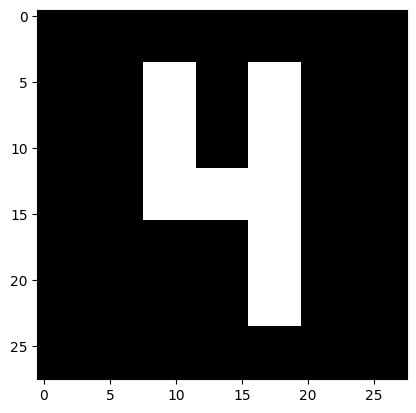

In [11]:
# Check prediction for manually inserted label

m = [[0,0,0,0,0,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,1,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0]]
m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
plt.imshow(m.reshape(28,28))
prediction = make_predictions(m.reshape(784,1), W1, b1, W2, b2)
prediction